In [1]:
!pip install imutils

  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25858 sha256=e56b68dc773f3ad6130681f4415cd9c2e3f2881ae8315c7c4360f845ba3ccc0e
  Stored in directory: /root/.cache/pip/wheels/86/d7/0a/4923351ed1cec5d5e24c1eaf8905567b02a0343b24aa873df2
Successfully built imutils
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
import os
import random 
import cv2
import imutils
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
from keras.utils import np_utils
from keras.models import Sequential
from keras import optimizers
from sklearn.preprocessing import LabelBinarizer
from keras import backend as K
from keras.layers import Dense, Activation, Flatten, Dense,MaxPooling2D, Dropout
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

In [3]:
dir = "../input/handwritten-characters/Train/"
train_data = []
img_size = 32
non_chars = ["#","$","&","@"]
for i in os.listdir(dir):
    if i in non_chars:
        continue
    count = 0
    sub_directory = os.path.join(dir,i)
    for j in os.listdir(sub_directory):
        count+=1
        if count > 4000:
            break
        img = cv2.imread(os.path.join(sub_directory,j),0)
        img = cv2.resize(img,(img_size,img_size))
        train_data.append([img,i])

In [4]:
len(train_data)

140000

In [5]:
val_dir = "../input/handwritten-characters/Validation/"
val_data = []
img_size = 32
for i in os.listdir(val_dir):
    if i in non_chars:
        continue
    count = 0
    sub_directory = os.path.join(val_dir,i)
    for j in os.listdir(sub_directory):
        count+=1
        if count > 1000:
            break
        img = cv2.imread(os.path.join(sub_directory,j),0)
        img = cv2.resize(img,(img_size,img_size))
        val_data.append([img,i])

In [6]:
len(val_data)

15209

In [7]:
random.shuffle(train_data)
random.shuffle(val_data)

In [8]:
train_X = []
train_Y = []
for features,label in train_data:
    train_X.append(features)
    train_Y.append(label)

In [9]:
val_X = []
val_Y = []
for features,label in val_data:
    val_X.append(features)
    val_Y.append(label)

In [10]:
LB = LabelBinarizer()
train_Y = LB.fit_transform(train_Y)
val_Y = LB.fit_transform(val_Y)

In [11]:
train_X = np.array(train_X)/255.0
train_X = train_X.reshape(-1,32,32,1)
train_Y = np.array(train_Y)

In [12]:
val_X = np.array(val_X)/255.0
val_X = val_X.reshape(-1,32,32,1)
val_Y = np.array(val_Y)

In [13]:
print(train_X.shape,val_X.shape)

(140000, 32, 32, 1) (15209, 32, 32, 1)


In [14]:
print(train_Y.shape,val_Y.shape)

(140000, 35) (15209, 35)


In [17]:
# Import additional layers for ResNet
from keras.layers import Input, Add, Conv2D, MaxPooling2D, BatchNormalization, Activation, Flatten, Dense, Dropout
from keras.models import Model

# Define a residual block
def residual_block(x, filters, kernel_size=3, stride=1):
    y = Conv2D(filters, kernel_size=kernel_size, strides=stride, padding='same')(x)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    
    y = Conv2D(filters, kernel_size=kernel_size, strides=1, padding='same')(y)
    y = BatchNormalization()(y)
    
    if stride != 1 or x.shape[-1] != filters:
        x = Conv2D(filters, kernel_size=1, strides=stride, padding='same')(x)
        x = BatchNormalization()(x)
    
    out = Add()([x, y])
    out = Activation('relu')(out)
    return out

In [18]:
# Build the ResNet-inspired model
inputs = Input(shape=(32, 32, 1))
x = Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = residual_block(x, filters=64)
x = residual_block(x, filters=64)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = residual_block(x, filters=128)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.25)(x)
outputs = Dense(35, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 16, 16, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [19]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(train_X, train_Y, epochs=10, batch_size=32, validation_data=(val_X, val_Y), verbose=1)

Epoch 1/10
4375/4375 [==============================] - 23s 5ms/step - loss: 0.9949 - accuracy: 0.6805 - val_loss: 0.4729 - val_accuracy: 0.8502
Epoch 2/10
4375/4375 [==============================] - 23s 5ms/step - loss: 0.5714 - accuracy: 0.8116 - val_loss: 0.3457 - val_accuracy: 0.8943
Epoch 3/10
4375/4375 [==============================] - 23s 5ms/step - loss: 0.3703 - accuracy: 0.8790 - val_loss: 0.2457 - val_accuracy: 0.9243
Epoch 4/10
4375/4375 [==============================] - 24s 5ms/step - loss: 0.2938 - accuracy: 0.9036 - val_loss: 0.3068 - val_accuracy: 0.8732
Epoch 5/10
4375/4375 [==============================] - 24s 5ms/step - loss: 0.2501 - accuracy: 0.9168 - val_loss: 0.2300 - val_accuracy: 0.9243
Epoch 6/10
4375/4375 [==============================] - 24s 5ms/step - loss: 0.2252 - accuracy: 0.9241 - val_loss: 0.2414 - val_accuracy: 0.9106
Epoch 7/10
4375/4375 [==============================] - 24s 5ms/step - loss: 0.2076 - accuracy: 0.9285 - val_loss: 0.3105 - val_ac

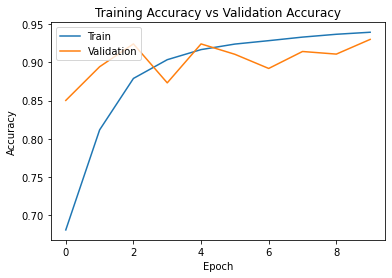

In [20]:
# Plot accuracy and loss
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training Accuracy vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

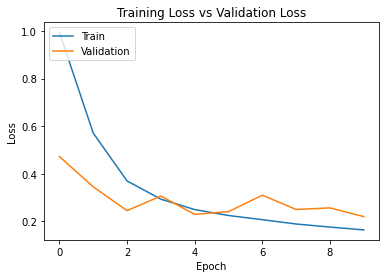

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [22]:
model.save("model.h5")

## Recognition and Post-Processing 
1. The sort contours function is used to get the correct order of individual characters for correct output extraction. In this case for extracting a single word, a left to right sorting of individual characters is needed.
2. The get letters function fetches the list of letters and get word function gets the individual word. 

In [23]:
# Define contour sorting function (exact same as original)
def sort_contours(cnts, method="left-to-right"):
    reverse = False
    i = 0
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
    key=lambda b:b[1][i], reverse=reverse))
    return (cnts, boundingBoxes)

In [24]:
def get_letters(img):
    letters = []
    image = cv2.imread(img)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, thresh1 = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
    dilated = cv2.dilate(thresh1, None, iterations=2)

    cnts = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sort_contours(cnts, method="left-to-right")[0]
    
    for c in cnts:
        if cv2.contourArea(c) > 10:
            (x, y, w, h) = cv2.boundingRect(c)
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        roi = gray[y:y + h, x:x + w]
        thresh = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        thresh = cv2.resize(thresh, (32, 32), interpolation=cv2.INTER_CUBIC)
        thresh = thresh.astype("float32") / 255.0
        thresh = np.expand_dims(thresh, axis=-1)
        thresh = thresh.reshape(1, 32, 32, 1)
        ypred = model.predict(thresh)
        ypred = LB.inverse_transform(ypred)
        [x] = ypred
        letters.append(x)
    return letters, image

In [25]:
def get_word(letter):
    word = "".join(letter)
    return word

BEWE5


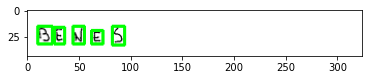

In [26]:
letter,image = get_letters("../input/handwriting-recognition/train_v2/train/TRAIN_00003.jpg")
word = get_word(letter)
print(word)
plt.imshow(image)

LIL0U


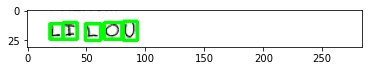

In [27]:
letter,image = get_letters("../input/handwriting-recognition/train_v2/train/TRAIN_00023.jpg")
word = get_word(letter)
print(word)
plt.imshow(image)

JAFFEUX


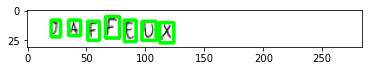

In [28]:
letter,image = get_letters("../input/handwriting-recognition/train_v2/train/TRAIN_00030.jpg")
word = get_word(letter)
print(word)
plt.imshow(image)

RUPP


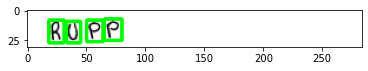

In [29]:
letter,image = get_letters("../input/handwriting-recognition/validation_v2/validation/VALIDATION_0005.jpg")
word = get_word(letter)
print(word)
plt.imshow(image)

VALENTJNE


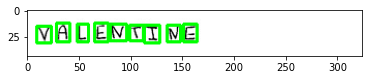

In [30]:
letter,image = get_letters("../input/handwriting-recognition/test_v2/test/TEST_0007.jpg")
word = get_word(letter)
print(word)
plt.imshow(image)